# Grapevine leaves classifier using CNN

In [1]:
#import data by kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
#loading dataset image
!kaggle datasets download -d muratkokludataset/grapevine-leaves-image-dataset

 97% 105M/109M [00:01<00:00, 80.6MB/s]
100% 109M/109M [00:01<00:00, 94.0MB/s]


In [4]:
#file unzip
import zipfile
zip_ref = zipfile.ZipFile('/content/grapevine-leaves-image-dataset.zip') 
zip_ref.extractall('/content')
zip_ref.close()

In [28]:
#importing the Dependinces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from os import listdir
from os.path import isdir, isfile, join
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import InceptionV3, VGG16
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from livelossplot import PlotLossesKeras

In [8]:
data_dir = '/content/Grapevine_Leaves_Image_Dataset'

img_width = 150
img_height = 150

EPOCHS = 20
BATCH_SIZE = 32

IMAGE_SHAPE = (img_width, img_height)

In [9]:
#data creat
datagen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    vertical_flip=True,
    height_shift_range=0.3,
    width_shift_range=0.3,
    brightness_range=[0.1,0.9],
    rotation_range=90,
    validation_split=0.1,
    zoom_range=0.1
)

In [10]:
#check class
CLASSES = sorted(listdir(data_dir))
CLASSES

['Ak',
 'Ala_Idris',
 'Buzgulu',
 'Dimnit',
 'Grapevine_Leaves_Image_Dataset_Citation_Request.txt',
 'Nazli']

In [11]:
#dataset train and test dataset
train_gen = datagen.flow_from_directory(
    data_dir, 
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    subset='training',
    shuffle=True,
    seed=242
)

validation_gen = datagen.flow_from_directory(
    data_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes = CLASSES,
    subset='validation',
    shuffle=True,
    seed=116,
#)

Found 450 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


In [16]:
#data plot 
def plot_images(path, datagen):
    
    plt.figure(figsize = (14,28))
    plt.suptitle('Augmented Data')
    
    index = 0
    for location in path:
        img = Image.open(location)
        img = img.resize((242,242))
        samples = np.expand_dims(img, 0)
        it = datagen.flow(samples, batch_size=1)
        
        # Show Original Image
        plt.subplot(10,5, index+1)
        plt.imshow(img)
        plt.axis('off')
        
        # Show Augmented Images
        for idx, i in enumerate(range(4)):
            index += 1
            plt.subplot(10,5, index+1)
            
            batch = it.next()
            image = batch[0].astype('uint8')
            plt.imshow(image)
            plt.axis('off')
        index += 1
        
    plt.tight_layout()
    plt.show()

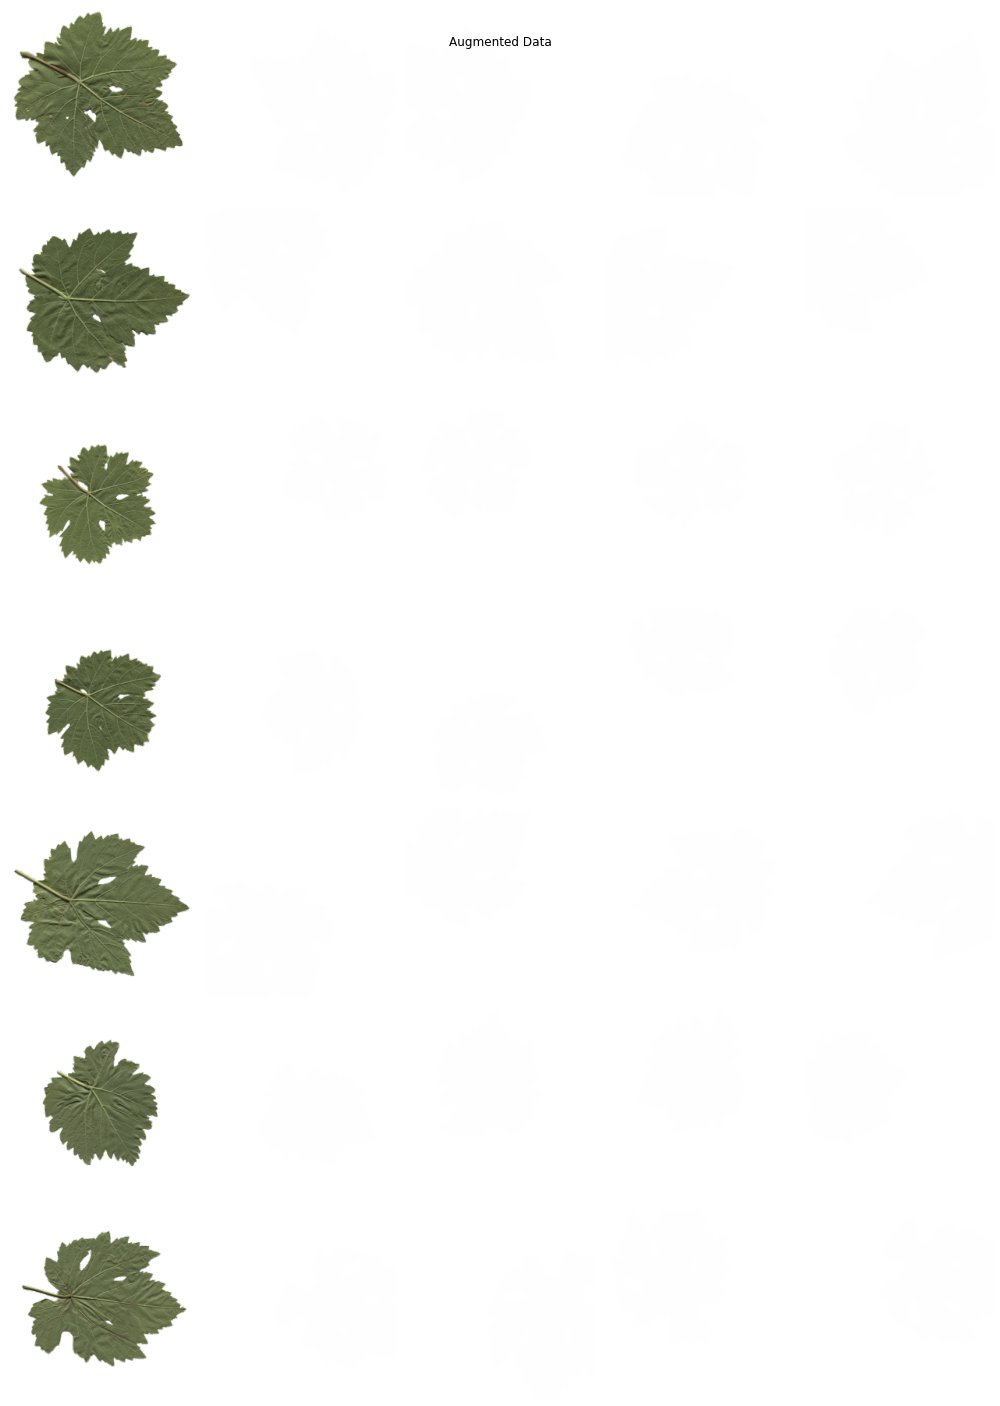

In [17]:
#check image
plot_images([
    '/content/Grapevine_Leaves_Image_Dataset/Ak/Ak (26).png',
    '/content/Grapevine_Leaves_Image_Dataset/Ak/Ak (5).png',
    '/content/Grapevine_Leaves_Image_Dataset/Ak/Ak (95).png',
    '/content/Grapevine_Leaves_Image_Dataset/Ak/Ak (99).png',
    '/content/Grapevine_Leaves_Image_Dataset/Ala_Idris/Ala_Idris (1).png',
    '/content/Grapevine_Leaves_Image_Dataset/Ala_Idris/Ala_Idris (20).png',
    '/content/Grapevine_Leaves_Image_Dataset/Ala_Idris/Ala_Idris (11).png'
], datagen)

In [20]:
inception_model = Sequential()

# base_model
inception_base_model = InceptionV3(include_top=False,input_shape=(img_width, img_height,3))
inception_base_model.trainable=False

inception_model.add(inception_base_model)

#### Fully-Connected Layer ####
inception_model.add(GlobalAveragePooling2D())
inception_model.add(Dropout(0.15))
inception_model.add(Dense(1024, activation='relu'))
inception_model.add(Dense(len(CLASSES), activation='softmax'))

In [21]:
#check model summary
inception_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 23,907,110
Trainable params: 2,104,326
Non-trainable params: 21,802,784
__________________________________

In [22]:
#using Vgg16 model
vgg16_model = Sequential()

# base_model
vgg16_base_model = VGG16(include_top=False,input_shape=(img_width, img_height,3))
vgg16_base_model.trainable=False

vgg16_model.add(vgg16_base_model)

#### Fully-Connected Layer ####
vgg16_model.add(GlobalAveragePooling2D())
vgg16_model.add(Dropout(0.15))
vgg16_model.add(Dense(1024, activation='relu'))
vgg16_model.add(Dense(len(CLASSES), activation='softmax'))


58889256/58889256 [==============================] - 0s 0us/step


In [23]:
#check model summary
vgg16_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dense_3 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 15,246,150
Trainable params: 531,462
Non-trainable params: 14,714,688
____________________________________

In [29]:
steps_for_each_epoch = train_gen.samples // BATCH_SIZE
validation_steps_for_each_epoch = validation_gen.samples // BATCH_SIZE

OPTIMIZER = Adam(learning_rate=0.0001)

#compile model
inception_model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

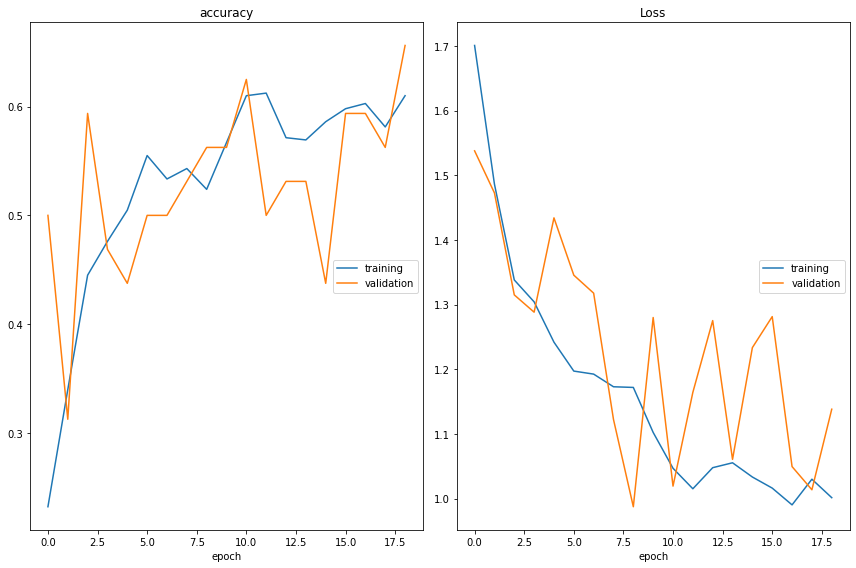

accuracy
	training         	 (min:    0.232, max:    0.612, cur:    0.610)
	validation       	 (min:    0.312, max:    0.656, cur:    0.656)
Loss
	training         	 (min:    0.990, max:    1.701, cur:    1.001)
	validation       	 (min:    0.987, max:    1.538, cur:    1.138)
14/14 [==============================] - 6s 438ms/step - loss: 1.0013 - accuracy: 0.6100 - val_loss: 1.1382 - val_accuracy: 0.6562


In [30]:
## save model after every epoch ##
checkpointer = ModelCheckpoint(filepath='img_model.trained.weights.hdf5', verbose=1, save_best_only=True)

## Early stopping to stop over training
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

history = inception_model.fit(
    train_gen, 
    epochs=EPOCHS, 
    steps_per_epoch=steps_for_each_epoch,
    validation_data=validation_gen,
    validation_steps=validation_steps_for_each_epoch,
    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
    verbose=True
)

In [31]:
#check accuracy score
test_loss, test_acc = inception_model.evaluate(validation_gen)
print('test accuracy : ', test_acc)

2/2 [==============================] - 1s 1s/step - loss: 1.1581 - accuracy: 0.5400
test accuracy :  0.5400000214576721


In [33]:
#save model
trained_model = load_model('/content/img_model.trained.weights.hdf5')

In [36]:
#test image 
def predict_img(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img)/255.0

    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    p = trained_model.predict(img[np.newaxis,...])
    print('Confidence: ',str(round(np.max(p[0])*100, 2))+'%')
    print('Class: ',CLASSES[np.argmax(p[0])])
    
def predict_external_img(full_img_path):
    img = image.load_img(full_img_path, target_size=(300, 300))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img)/255.0

    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    p = trained_model.predict(img[np.newaxis,...])
    print('Confidence: ',str(round(np.max(p[0])*100, 2))+'%')
    print('Class: ',CLASSES[np.argmax(p[0])])

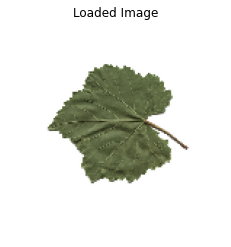

1/1 [==============================] - 2s 2s/step
Confidence:  65.92%
Class:  Buzgulu


In [37]:
predict_img('/content/Grapevine_Leaves_Image_Dataset/Buzgulu/Buzgulu (1).png')